In [37]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor,Compose,RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
import random
from collections import Counter

Import Data

In [2]:
class StoneDataset(Dataset):
    def __init__(self, root, split="train", transforms=None):
        """
        root: 数据集根目录
        split: 'train', 'val', 或 'test'
        transforms: 图像预处理变换
        """
        # Train size: 102213, Val size: 15000, Test size: 15000
        self.root = root
        self.split = split
        self.transforms = transforms
        self.samples = []
        self.labels = []

        # 根据 split 加载对应的数据
        if split in ["train", "val"]:
            # 加载训练集或验证集
            csv_path = os.path.join(root, f"{split}_labels.csv")
            if not os.path.exists(csv_path):
                raise FileNotFoundError(f"{csv_path} not found.")
            
            # 读取 CSV 文件
            df = pd.read_csv(csv_path)
            for _, row in df.iterrows():
                img_path = os.path.join(root, split, row["id"])
                self.samples.append(img_path)
                self.labels.append(int(row["label"]))  # label 已为 0, 1, 2
        elif split == "test":
            # 加载测试集（无标签，仅图像路径）
            test_ids_path = os.path.join(root, "test_ids.csv")
            if not os.path.exists(test_ids_path):
                raise FileNotFoundError(f"{test_ids_path} not found.")
            
            # 读取测试集 ID
            df = pd.read_csv(test_ids_path)
            for _, row in df.iterrows():
                img_path = os.path.join(root, "test_images", row["id"])
                self.samples.append(img_path)
                self.labels.append(None)  # 测试集无标签，占位符
        else:
            raise ValueError(f"Invalid split: {split}. Must be 'train', 'val', or 'test'.")

    def __getitem__(self, index):
        img_path = self.samples[index]
        label = self.labels[index]

        # 加载图像
        image = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        # 对于测试集，label 为 None，仅返回图像
        if self.split == "test":
            return image, img_path  # 返回图像和路径以便生成提交文件
        return image, label  # 返回图像和标签

    def __len__(self):
        return len(self.samples)

In [41]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 加载数据集
train_dataset = StoneDataset(root="./dataset/train_val", split="train", transforms=transform)
val_dataset = StoneDataset(root="./dataset/train_val", split="val", transforms=transform)
test_dataset = StoneDataset(root="./dataset/test", split="test", transforms=transform)   # for Kaggle test only

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# 测试加载
img, label = train_dataset[0]
print(f"Sample image shape: {img.shape}, Label: train_dataset{label}")

Train size: 102213
Val size: 15000
Test size: 15000
Sample image shape: torch.Size([3, 224, 224]), Label: train_dataset0


In [28]:
batch_size = 128
# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=4, pin_memory=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                    num_workers=4, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

# Check dataset
print(f"Train batches: {len(trainloader)}")
print(f"Valid batches: {len(valloader)}")
print(f"Test batches: {len(testloader)}")

Train batches: 799
Valid batches: 118
Test batches: 118


In [29]:
for data, _ in trainloader:
    print(data.shape)  # (batch_size, C, H, W)
    break

torch.Size([128, 3, 224, 224])


EDA分析

In [39]:
def analyze_dataset(dataset, name="train"):
    print(f"\n===== 数据集：{name}（共 {len(dataset)} 张）=====")

    # 标签分布（测试集没有标签）
    if name != "test":
        label_counts = Counter(dataset.labels)
        print("标签分布：")
        for label, count in sorted(label_counts.items()):
            print(f"类别 {label}: {count} 张图像")
        # 可视化标签分布
        plt.figure(figsize=(4, 3))
        plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
        plt.xlabel("Tag Category")
        plt.ylabel("Count")
        plt.title(f"{name} Label distribution")
        plt.show()

    # 图像尺寸 & 像素统计
    sample_size = min(1000, len(dataset))
    img_sizes, means, stds = [], [], []
    to_tensor = transforms.ToTensor()

    for i in range(sample_size):
        img_path = dataset.samples[i]
        image = Image.open(img_path).convert("RGB")
        img_sizes.append(image.size)
        tensor = to_tensor(image)
        means.append(tensor.mean().item())
        stds.append(tensor.std().item())

    widths, heights = zip(*img_sizes)
    print(f"图像宽度：均值={np.mean(widths):.2f}，标准差={np.std(widths):.2f}")
    print(f"图像高度：均值={np.mean(heights):.2f}，标准差={np.std(heights):.2f}")
    print(f"像素均值：{np.mean(means):.4f}")
    print(f"像素标准差：{np.mean(stds):.4f}")

    # 可视化尺寸分布
    plt.figure(figsize=(6, 4))
    plt.hist(widths, bins=30, alpha=0.5, label="Width")
    plt.hist(heights, bins=30, alpha=0.5, label="Height")
    plt.legend()
    plt.title(f"{name} Image size distribution")
    plt.show()


===== 数据集：train（共 102213 张）=====
标签分布：
类别 0: 24985 张图像
类别 1: 30896 张图像
类别 2: 46332 张图像


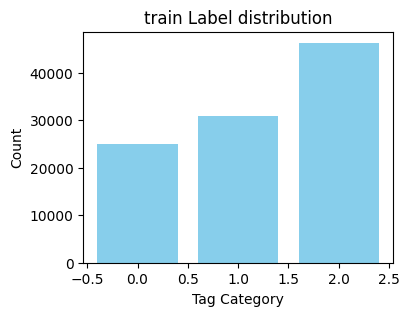

图像宽度：均值=1625.59，标准差=421.92
图像高度：均值=1183.88，标准差=394.78
像素均值：0.4376
像素标准差：0.1801


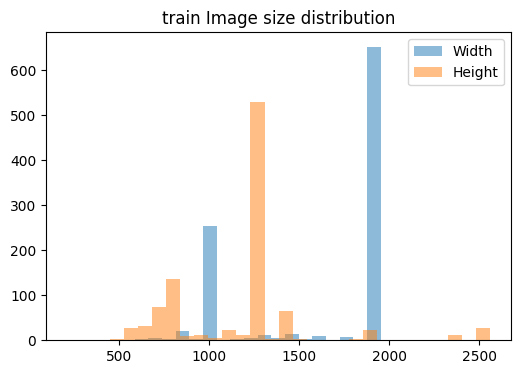


===== 数据集：val（共 15000 张）=====
标签分布：
类别 0: 5000 张图像
类别 1: 5000 张图像
类别 2: 5000 张图像


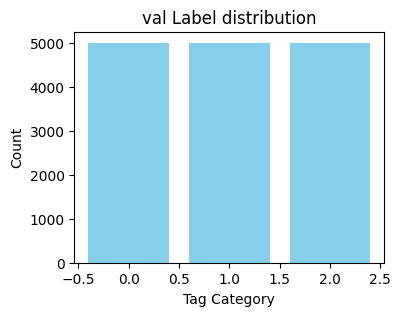

图像宽度：均值=1593.87，标准差=435.34
图像高度：均值=1159.68，标准差=394.15
像素均值：0.4377
像素标准差：0.1794


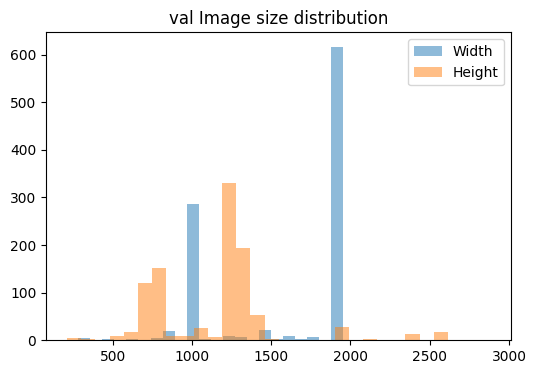


===== 数据集：test（共 15000 张）=====
图像宽度：均值=1615.20，标准差=435.54
图像高度：均值=1161.73，标准差=382.42
像素均值：0.4473
像素标准差：0.1778


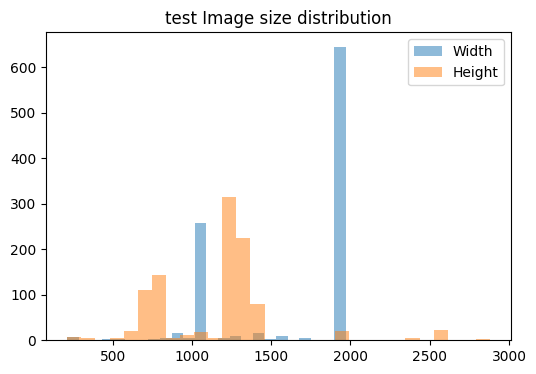

In [40]:
analyze_dataset(train_dataset, name="train")
analyze_dataset(val_dataset, name="val")
analyze_dataset(test_dataset, name="test")

Model

In [16]:
seed = 1
random.seed(seed)  # Python 内置随机数种子
np.random.seed(seed)  # NumPy 随机种子
torch.manual_seed(seed)  # PyTorch 随机种子
torch.cuda.manual_seed(seed)  # 设置 CUDA 的随机种子
torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU 也要设置
torch.backends.cudnn.deterministic = True  # 让 CNN 结果可复现
torch.backends.cudnn.benchmark = False  # 关闭自动优化
transform_train = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(p=0.2),  # 50% 概率水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动
    transforms.RandomRotation(15),           # 旋转 ±15 度
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),  # 输出：6x32x32 -> 池化后：6x16x16
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),            # 输出：16x12x12 -> 池化后：16x6x6
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(120)  # 自动推断输入特征维度
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
model = LeNet()
print(model) # 打印网络结构
x = torch.randn(1, 3, 32, 32)
print(model(x).shape) # 测试网络输出

LeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([1, 10])


In [19]:
# 训练一个batch的函数
def train_one_batch(model, inputs, labels, optimizer, criterion, device):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    # print(f"inputs shape: {inputs.shape}")
    # print(f"outputs shape: {outputs.shape}")
    # print(f"labels shape: {labels.shape}")
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    return loss, outputs

In [20]:
def predict(model, loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # Store predicted classes
    image_ids = []    # Store image filenames
    
    with torch.no_grad():  # Disable gradient computation
       for images, img_paths in tqdm(loader, desc="Predicting on test set"):
           images = images.to(device)  # Move images to the specified device
           outputs = model(images)     # Forward pass to get model outputs
           _, predicted = torch.max(outputs, 1)  # Get predicted classes
           
           # Collect predictions and image IDs
           predictions.extend(predicted.cpu().numpy())
           image_ids.extend([os.path.basename(path) for path in img_paths])
    return image_ids, predictions

In [34]:
# 测试函数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    # print(1)
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print(2)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [33]:
# 超参数
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


# 记录训练过程中的指标
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []

In [ ]:
# 训练循环
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    total_samples = 0
    
    # 按batch训练
    for i, batch_data in enumerate(trainloader):
        inputs, labels = batch_data
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss, batch_output = train_one_batch(model, inputs, labels, optimizer, criterion, device)
        # print(i)
        epoch_loss += batch_loss.item()
        _, batch_prediction = torch.max(batch_output.data, 1)
        batch_size = labels.size(0)
        total_samples += batch_size
        epoch_correct += (batch_prediction == labels).sum().item()
            
    avg_train_loss = epoch_loss / len(trainloader)
    avg_train_acc = epoch_correct / total_samples
    
    # 测试
    val_loss, val_acc = evaluate(model, valloader, criterion, device)
    
    # 记录指标
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    learning_rates.append(scheduler.get_last_lr()[0])  # 记录当前学习率

    scheduler.step()
    
    # 打印训练状态
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')  # 打印当前学习率

Epoch [1/50]
Train Loss: 1.0759, Train Acc: 0.4466
Val Loss: 1.1352, Val Acc: 0.3333
Current Learning Rate: 0.009990
Epoch [2/50]
Train Loss: 1.0718, Train Acc: 0.4477
Val Loss: 1.1215, Val Acc: 0.3333
Current Learning Rate: 0.009961
Epoch [3/50]
Train Loss: 1.0701, Train Acc: 0.4522
Val Loss: 1.1268, Val Acc: 0.3333
Current Learning Rate: 0.009911
Epoch [4/50]
Train Loss: 1.0681, Train Acc: 0.4526
Val Loss: 1.1390, Val Acc: 0.3333
Current Learning Rate: 0.009843
Epoch [5/50]
Train Loss: 1.0674, Train Acc: 0.4533
Val Loss: 1.1388, Val Acc: 0.3333
Current Learning Rate: 0.009755
Epoch [6/50]
Train Loss: 1.0671, Train Acc: 0.4533
Val Loss: 1.1171, Val Acc: 0.3333
Current Learning Rate: 0.009649
Epoch [7/50]
Train Loss: 1.0672, Train Acc: 0.4530
Val Loss: 1.1490, Val Acc: 0.3333
Current Learning Rate: 0.009524
Epoch [8/50]
Train Loss: 1.0667, Train Acc: 0.4533
Val Loss: 1.1359, Val Acc: 0.3333
Current Learning Rate: 0.009382
Epoch [9/50]
Train Loss: 1.0668, Train Acc: 0.4533
Val Loss: 1.1

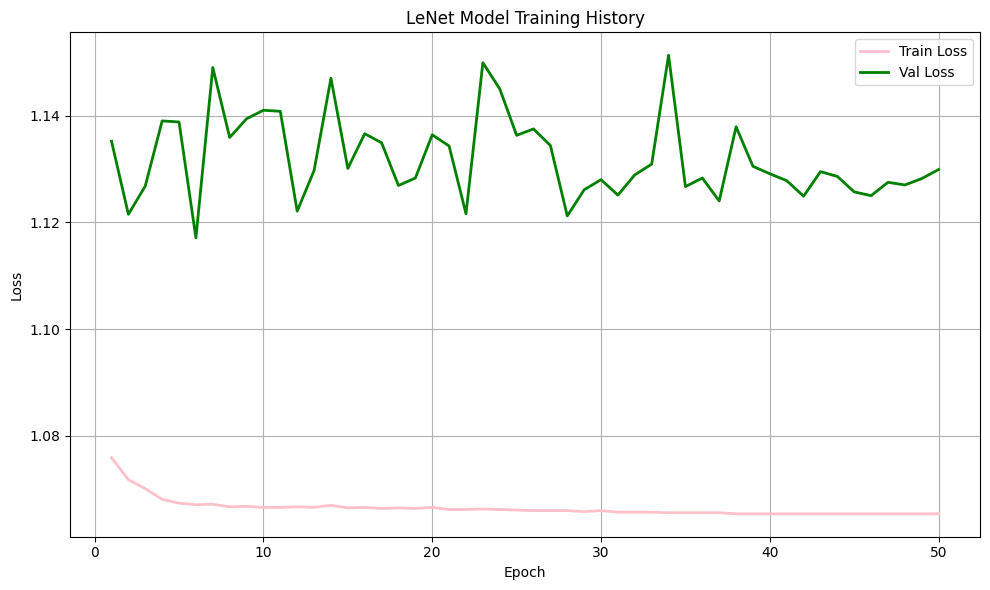

In [43]:
import matplotlib.pyplot as plt

def plot_training_log():
    epochs = list(range(1, 51))

    train_loss = [
        1.0759, 1.0718, 1.0701, 1.0681, 1.0674, 1.0671, 1.0672, 1.0667, 1.0668, 1.0666,
        1.0666, 1.0667, 1.0666, 1.0670, 1.0665, 1.0666, 1.0664, 1.0665, 1.0664, 1.0666,
        1.0662, 1.0662, 1.0663, 1.0662, 1.0661, 1.0660, 1.0660, 1.0660, 1.0658, 1.0660,
        1.0657, 1.0657, 1.0657, 1.0656, 1.0656, 1.0656, 1.0656, 1.0654, 1.0654, 1.0654,
        1.0654, 1.0654, 1.0654, 1.0654, 1.0654, 1.0654, 1.0654, 1.0654, 1.0654, 1.0654
    ]

    val_loss = [
        1.1352, 1.1215, 1.1268, 1.1390, 1.1388, 1.1171, 1.1490, 1.1359, 1.1394, 1.1410,
        1.1408, 1.1221, 1.1297, 1.1470, 1.1301, 1.1366, 1.1349, 1.1269, 1.1283, 1.1364,
        1.1343, 1.1216, 1.1499, 1.1450, 1.1363, 1.1375, 1.1344, 1.1212, 1.1261, 1.1280,
        1.1251, 1.1289, 1.1309, 1.1513, 1.1267, 1.1283, 1.1240, 1.1379, 1.1305, 1.1291,
        1.1278, 1.1249, 1.1295, 1.1286, 1.1257, 1.1250, 1.1275, 1.1270, 1.1282, 1.1299
    ]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='pink', linewidth=2)
    plt.plot(epochs, val_loss, label='Val Loss', color='green', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LeNet Model Training History')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_log()


In [45]:
def predict(model, test_loader):
    model.eval()
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            filenames.extend(list(paths))
            predictions.extend(preds.cpu().numpy())
    
    return filenames, predictions

# 测试集加载
test_loader = DataLoader(
    StoneDataset(root="./dataset/test", split="test", transforms=transform),
    batch_size=batch_size, shuffle=False
)

# 生成预测结果
filenames, preds = predict(model, test_loader)

In [46]:
df = pd.DataFrame({"filename": filenames, "label": preds})
df.to_csv("submission.csv", index=False)